<a href="https://colab.research.google.com/github/kishan20-00/Forecasting_with_Machine_Learning/blob/main/Forecasting_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [5]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

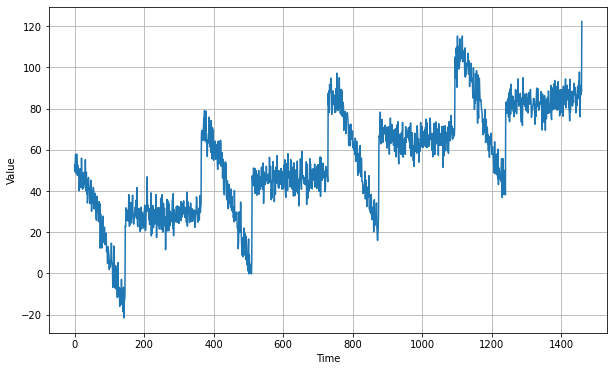

In [6]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Forecasting with Machine Learning

In [7]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Linear Model

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
31/31 [==============================] - 4s 96ms/step - loss: 325.1985 - mae: 325.6984 - val_loss: 227.6627 - val_mae: 228.1627
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 992.6786 - mae: 993.1786 - val_loss: 563.4246 - val_mae: 563.9246
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 1081.2277 - mae: 1081.7271 - val_loss: 29.9918 - val_mae: 30.4891
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 616.4951 - mae: 616.9951 - val_loss: 79.2645 - val_mae: 79.7634
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 701.1809 - mae: 701.6803 - val_loss: 1440.6594 - val_mae: 1441.1594
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 369.0440 - mae: 369.5438 - val_loss: 981.9866 - val_mae: 982.4866
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 868.9808 - mae: 869.4804 - val_loss: 2337.4480 - val_mae: 2337.9480
Epoch 8/100
31/31 [====

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 64.3516 - mae: 64.8511 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 48.9375 - mae: 49.4367 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 31.1545 - mae: 31.6532 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 15.0073 - mae: 15.5013 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 9.9920 - mae: 10.4800 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 9.9703 - mae: 10.4652 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 9.9226 - mae: 10.4109 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 9.8972 - mae: 10.3842 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 1s 9ms/step - loss: 9.8562 - mae: 10.3449 - lr:

(1e-06, 0.001, 0.0, 20.0)

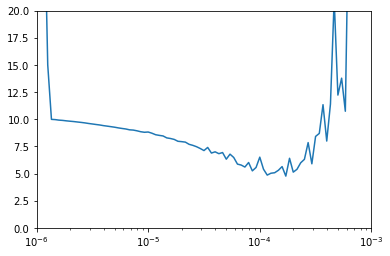

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 12ms/step - loss: 401.1161 - mae: 401.6161 - val_loss: 1153.0470 - val_mae: 1153.5470
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 794.0989 - mae: 794.5989 - val_loss: 144.7811 - val_mae: 145.2811
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 911.2029 - mae: 911.7029 - val_loss: 2567.6021 - val_mae: 2568.1021
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 1690.2328 - mae: 1690.7324 - val_loss: 4559.8193 - val_mae: 4560.3193
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 880.8487 - mae: 881.3484 - val_loss: 86.9435 - val_mae: 87.4424
Epoch 6/500
31/31 [==============================] - 1s 16ms/step - loss: 678.1648 - mae: 678.6648 - val_loss: 1833.9159 - val_mae: 1834.4159
Epoch 7/500
31/31 [==============================] - 1s 18ms/step - loss: 776.8835 - mae: 777.3834 - val_loss: 1425.1792 - val_mae: 1425.6792
Epoch 8/500
31

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 7ms/step


In [15]:
lin_forecast.shape

(461,)

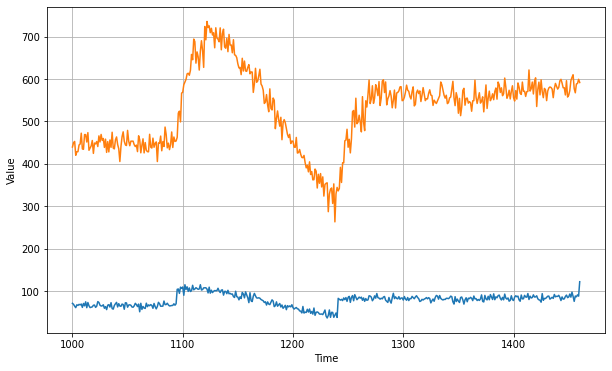

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [17]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

450.6909

Dense Model Forecasting

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 13.7514 - mae: 14.2463 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 13.2794 - mae: 13.7734 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 12.6906 - mae: 13.1849 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 12.0250 - mae: 12.5183 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 11.2788 - mae: 11.7707 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 10.4594 - mae: 10.9495 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 9.5903 - mae: 10.0822 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 8.7032 - mae: 9.1917 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8541 - mae: 8.3407 - lr:

(1e-07, 0.005, 0.0, 30.0)

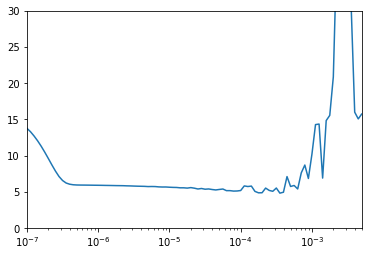

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 14ms/step - loss: 47.7395 - mae: 48.2380 - val_loss: 77.1639 - val_mae: 77.6639
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 40.0333 - mae: 40.5319 - val_loss: 74.3454 - val_mae: 74.8454
Epoch 3/500
31/31 [==============================] - 0s 8ms/step - loss: 37.1085 - mae: 37.6070 - val_loss: 71.5756 - val_mae: 72.0756
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 34.9286 - mae: 35.4278 - val_loss: 68.8460 - val_mae: 69.3460
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 32.5178 - mae: 33.0168 - val_loss: 66.1523 - val_mae: 66.6523
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 30.2459 - mae: 30.7451 - val_loss: 63.5407 - val_mae: 64.0407
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 28.0910 - mae: 28.5888 - val_loss: 60.9908 - val_mae: 61.4908
Epoch 8/500
31/31 [==============================] - 0

In [21]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 1s 7ms/step


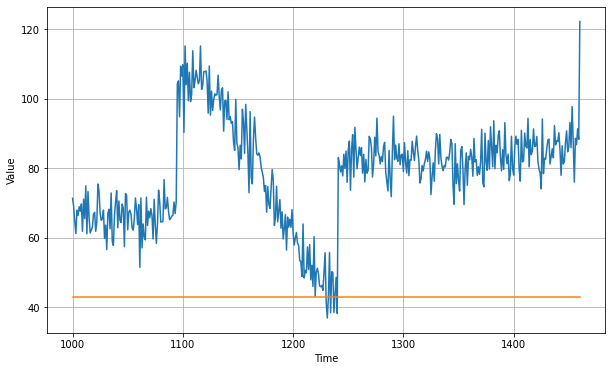

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [23]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

35.758564